In [1]:
import os
import zipfile
import tvm
import mxnet as mx
import cv2
import numpy as np
import nnvm
from nnvm import compiler
from nnvm.frontend import from_mxnet
from tvm.contrib.download import download
from tvm.contrib import graph_runtime
from mxnet.model import load_checkpoint

/home/wk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# test tvm 
# sym = mx.sym.load("./deploy_ssd_vgg16_reduced_512-det-symbol.json")
# sym1,arg_params,aux_params = load_checkpoint("./deploy_ssd_vgg16_reduced_512-det",25)
# mobilenet v2 
# sym = mx.sym.load("./ssd_mobilenetv2_512/deploy_ssd_mobilenet_v2_512-det-symbol.json")
sym,arg_params,aux_params = load_checkpoint("./original_deploy_ssd/deploy_ssd_mobilenet_v2_512",236)

In [4]:
net,params = from_mxnet(sym,arg_params,aux_params)

In [5]:
opt_level = 3
# target = tvm.target.current_target()
dshape = (1, 3, 512, 512)
dtype = "float32"
target = "llvm"
with nnvm.compiler.build_config(opt_level=opt_level):
    graph, lib, params = nnvm.compiler.build(
        net, target, shape={"data": dshape}, params=params,dtype=dtype)

Cannot find config for target=llvm, workload=('conv2d', (1, 3, 512, 512, 'float32'), (32, 3, 3, 3, 'float32'), (2, 2), (1, 1), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 32, 256, 256, 'float32'), (32, 32, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 32, 256, 256, 'float32'), (16, 32, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 16, 256, 256, 'float32'), (96, 16, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 96, 128, 128, 'float32'), 

In [7]:
# Preprocess image
test_image_path = "test.jpg"
image = cv2.imread(test_image_path)
ctx = tvm.cpu()
img_data = cv2.resize(image, (dshape[2], dshape[3]))
img_data = img_data[:, :, (2, 1, 0)].astype(np.float32)
img_data -= np.array([123, 117, 104])
img_data = np.transpose(np.array(img_data), (2, 0, 1))
img_data = np.expand_dims(img_data, axis=0)
# Build TVM runtime
import time
m = graph_runtime.create(graph, lib, ctx)
m.set_input('data', tvm.nd.array(img_data.astype(dtype)))
m.set_input(**params)
start = time.time()
# execute
m.run()
tvm_output = m.get_output(0)
# img_data.shape
print(time.time()-start)

0.28772830963134766


In [8]:
# get outputs
tvm_output = m.get_output(0)
tvm_output

<tvm.NDArray shape=(1, 3060, 6), cpu(0)>
array([[[14.        ,  0.9190676 ,  0.73617274,  0.0954268 ,
          0.82349914,  0.37438053],
        [-1.        ,  0.88103014,  0.7346359 ,  0.09906204,
          0.82756585,  0.38045877],
        [14.        ,  0.8223471 ,  0.8533739 ,  0.08439954,
          0.94776404,  0.37955368],
        ...,
        [-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        ]]], dtype=float32)

In [9]:
class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
               "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
               "sheep", "sofa", "train", "tvmonitor"]
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

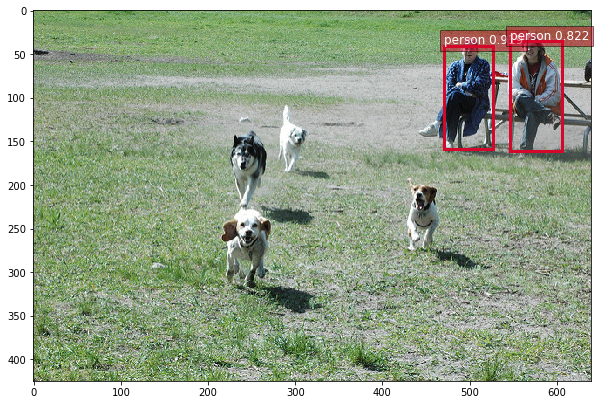

In [13]:
display(image, tvm_output.asnumpy()[0], thresh=0.55)

In [48]:
## test yolo3 mobilenet1.0 not exists
# from mxnet import gluon
# import gluoncv as gcv
# from mxnet import ndarray as nd
# net = gcv.model_zoo.get_model('yolo3_mobilenet1.0_custom',pretrained=True)


In [17]:
# test results for pc train
# from mxnet import gluon
ctx = mx.cpu(1)
# net = gluon.nn.SymbolBlock.imports('./ssd_mobilenet_v2_512-symbol.json', ['data'],'./ssd_mobilenet_v2_512-0236.params', ctx=ctx)
sym,arg_params,aux_params = load_checkpoint("./original_deploy_ssd/deploy_ssd_mobilenet_v2_512",236)

In [22]:
from mxnet import gluon
import gluoncv as gcv
from mxnet import ndarray as nd
net = gluon.nn.SymbolBlock(outputs=sym,inputs=mx.sym.var('data'))
net.collect_params().load('./original_deploy_ssd/deploy_ssd_mobilenet_v2_512-0236.params', allow_missing=True)


In [40]:
img_data.shape

(1, 3, 512, 512)

In [42]:
y = net(nd.array(img_data))

In [43]:
y[0]


[[14.          0.91906863  0.7361727   0.09542687  0.8234992   0.3743804 ]
 [-1.          0.88103026  0.734636    0.09906198  0.82756585  0.38045877]
 [14.          0.8223478   0.8533739   0.08439963  0.94776404  0.37955362]
 ...
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]]
<NDArray 3060x6 @cpu(0)>

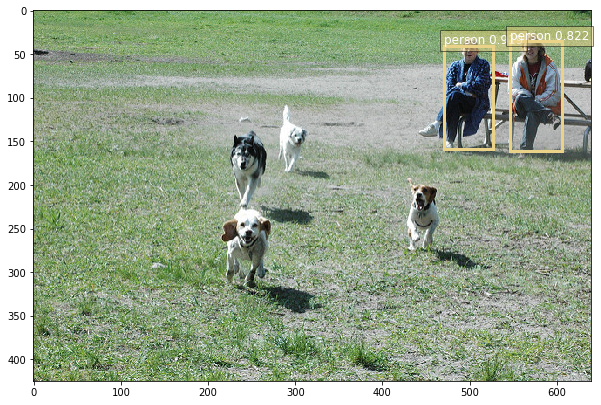

In [44]:
display(image, y.asnumpy()[0], thresh=0.5)